In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from typing import Tuple

print("Cuda available :", torch.cuda.is_available())
print("cuda version : ", torch.backends.cudnn.version())
print("No of GPU : ", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"Device {i} Name: ", torch.cuda.get_device_name(i))
print(torch.version.cuda)

Cuda available : True
cuda version :  8907
No of GPU :  1
Device 0 Name:  NVIDIA GeForce GTX 1650 with Max-Q Design
12.1


In [2]:
def loadAndPreprocessImage(image_path, target_size):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image at path '{image_path}' not found.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0  
    return image

In [3]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block( dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        padding_size = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            padding_size = 1
        else:
            raise NotImplementedError( 'padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=padding_size, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        padding_size = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            padding_size = 1
        else:
            raise NotImplementedError( 'padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=padding_size, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [4]:
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, gpu_ids=[ ], padding_type='reflect'):
        assert (n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        self.input_nc = input_nc
        self.output_nc = 3
        self.ngf = ngf
        self.gpu_ids = gpu_ids

        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model1 = [ nn.ReflectionPad2d(3), nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias), norm_layer(ngf), nn.ReLU(True) ]
        model2 = [ nn.ReflectionPad2d(3), nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias), norm_layer(ngf), nn.ReLU(True) ]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model1 += [ nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias), norm_layer(ngf * mult * 2), nn.ReLU(True) ]
            model2 += [ nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias), norm_layer(ngf * mult * 2), nn.ReLU(True) ]

        pre_f_blocks = 4
        pre_l_blocks = 7
        mult = 2**n_downsampling

        for i in range(pre_f_blocks):
            model1 += [ ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias) ]
            model2 += [ ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias) ]

        model_pre = []
        for i in range(pre_f_blocks, pre_l_blocks):
            model_pre += [ ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        model_post = []
        for i in range(pre_l_blocks, n_blocks):
            model_post += [ ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        model_fusion = []
        model_fusion = [ nn.Conv2d(ngf * mult * 2, ngf * mult, kernel_size=3, padding=1, bias=use_bias), norm_layer(ngf * mult), nn.ReLU(True)]

        model = []
        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model_post += [ nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1, bias=use_bias), norm_layer(int(ngf * mult / 2)), nn.ReLU(True) ]
        
        model_post += [ nn.ReflectionPad2d(3)]
        model_post += [ nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model_post += [ nn.Tanh()]
        # input_nc2 = 3
        model = [ nn.ReflectionPad2d(3), nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias), norm_layer(ngf), nn.ReLU(True) ]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [ nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias), norm_layer(ngf * mult * 2), nn.ReLU(True) ]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks
            model += [ ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias) ]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [ nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1, bias=use_bias), norm_layer(int(ngf * mult / 2)), nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model          = nn.Sequential(*model)
        self.model1   = nn.Sequential(*model1)
        self.model2   = nn.Sequential(*model2)
        self.model_pre      = nn.Sequential(*model_pre)
        self.model_post     = nn.Sequential(*model_post)
        self.model_fusion   = nn.Sequential(*model_fusion)

    def forward(self, input1, input2):
        m1 = self.model1(input1)
        m2 = self.model2(input2)
        latent = self.model_pre(self.model_fusion(torch.cat([ m1, m2], dim=1)))
        intermediate = self.model_post(latent)
        out = self.model(intermediate)
        return out, latent, intermediate

In [5]:
class ResnetGeneratorReverse(nn.Module):
    # def __init__(self, input_nc=3, output_nc=3, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, gpu_ids=[ ], padding_type='reflect'):
    def __init__(self, input_nc=3, output_nc=3, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, gpu_ids=[], padding_type='reflect'):
        assert (n_blocks >= 0)
        super(ResnetGeneratorReverse, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        self.gpu_ids = gpu_ids
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model_pre1 = [nn.ReflectionPad2d(3), nn.Conv2d(3, ngf, kernel_size=7, padding=0, bias=use_bias), norm_layer(ngf), nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model_pre1 += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias), norm_layer(ngf * mult * 2), nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks
            model_pre1 += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model_pre1 += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1, bias=use_bias), norm_layer(int(ngf * mult / 2)), nn.ReLU(True)]
        model_pre1 += [nn.ReflectionPad2d(3)]
        model_pre1 += [nn.Conv2d(ngf, 3, kernel_size=7, padding=0)]
        model_pre1 += [nn.Tanh()]

        self.model_pre1 = nn.Sequential(*model_pre1)

        model = [nn.ReflectionPad2d(3), nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias), norm_layer(ngf), nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias), norm_layer(ngf * mult * 2), nn.ReLU(True)]

        pre_f_blocks = 4
        pre_l_blocks = 7
        mult = 2**n_downsampling

        for i in range(pre_f_blocks):
            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        model_pre = []
        for i in range(pre_f_blocks, pre_l_blocks):
            model_pre += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        model_post = []
        # model_post2 = []
        for i in range(pre_l_blocks, n_blocks):
            model_post += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]
            # model_post2 += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model_post += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1, bias=use_bias), norm_layer(int(ngf * mult / 2)), nn.ReLU(True)]
            # model_post2 += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1, bias=use_bias), norm_layer(int(ngf * mult / 2)), nn.ReLU(True)]

        model_post += [nn.ReflectionPad2d(3)]
        model_post += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model_post += [nn.Tanh()]

        # model_post2 += [nn.ReflectionPad2d(3)]
        # model_post2 += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        # model_post2 += [nn.Tanh()]

        self.model_post = nn.Sequential(*model_post)
        # self.model_post2 = nn.Sequential(*model_post2)
        self.model_pre = nn.Sequential(*model_pre)
        self.model = nn.Sequential(*model)

    def forward(self, input):
        # noise_tensor = torch.randn(input.size()) * 0.001
        # noise_tensor=noise_tensor.to('cuda')
        # add noise to the image tensor
        # noisy_tensor = input + noise_tensor

        # clamp the tensor to be between 0 and 1
        # noisy_tensor = torch.clamp(noisy_tensor, min=0.0, max=1.0)

        intermediate = self.model_pre1(input)
        latent = self.model(intermediate)
        fuse_ip = self.model_pre(latent)
        out1 = self.model_post(fuse_ip)
        out2 = self.model_post(fuse_ip)
        return out1, out2, latent, intermediate

In [6]:
import functools
import cv2
import numpy as np

if __name__ == "__main__":
    net = ResnetGenerator()
    secret_image_1_path = './original_images/fuse1.JPEG'
    secret_image_2_path = './original_images/fuse2.JPEG'
    stego_image_path = './fused_images/concat_image.JPEG'
    secret_image_1 = loadAndPreprocessImage(secret_image_1_path, (256, 256))
    secret_image_2 = loadAndPreprocessImage(secret_image_2_path, (256, 256))

    secret_image_1_tensor = torch.tensor(secret_image_1).permute(2, 0, 1).unsqueeze(0).float()
    secret_image_2_tensor = torch.tensor(secret_image_2).permute(2, 0, 1).unsqueeze(0).float()
    secret_image_1_np = secret_image_1_tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    secret_image_2_np = secret_image_2_tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    # encoded1, encoded2, output, concatenated, original_concatenated = net(secret_image_1_tensor, secret_image_2_tensor)
    output, latent, intermediate = net(secret_image_1_tensor, secret_image_2_tensor)
    print(output.shape)
    print(latent.shape)
    print(intermediate.shape)

    stego_image_np = torch.tensor(output).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    stego_image_np = (stego_image_np * 255).astype(np.uint8)

    reverse_net = ResnetGeneratorReverse()
    stego_image = loadAndPreprocessImage(stego_image_path, (256, 256))
    stego_image_tensor = torch.tensor(stego_image).permute(2, 0, 1).unsqueeze(0).float()
    out1, out2, rev_latent, rev_intermediate = reverse_net(stego_image_tensor)
    print(out1.shape)
    print(out2.shape)
    print(rev_latent.shape)
    print(rev_intermediate.shape)

    encoded1_np = torch.tensor(out1).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    encoded1_np = (encoded1_np * 255).astype(np.uint8)

    encoded2_np = torch.tensor(out2).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    encoded2_np = (encoded2_np * 255).astype(np.uint8)

    concatenated = torch.tensor(rev_latent).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    concatenated = (concatenated * 255).astype(np.uint8)

    original_concatenated = torch.tensor(rev_intermediate).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    original_concatenated = (original_concatenated * 255).astype(np.uint8)

    cv2.imwrite(stego_image_path, stego_image_np)

C:\Users\Kimuthu Kisal\AppData\Local\Temp\ipykernel_3652\4023217661.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stego_image_np = torch.tensor(output).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()


torch.Size([1, 3, 256, 256])
torch.Size([1, 256, 64, 64])
torch.Size([1, 3, 256, 256])


FileNotFoundError: Image at path './fused_images/concat_image.JPEG' not found.

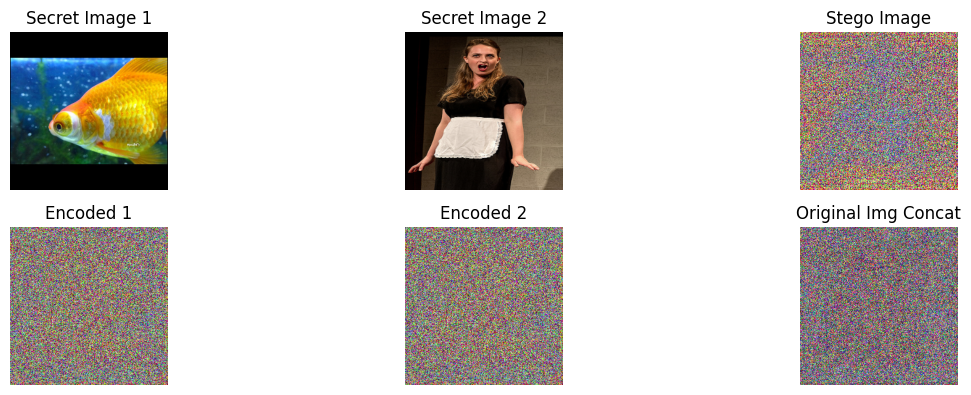

In [32]:
plt.figure(figsize=(12, 6))

plt.subplot(3, 3, 1)
plt.title('Secret Image 1')
plt.imshow(cover_image_np)
plt.axis('off')

plt.subplot(3, 3, 2)
plt.title('Secret Image 2')
plt.imshow(payload_image_np)
plt.axis('off')

plt.subplot(3, 3, 3)
plt.title('Stego Image')
plt.imshow(stego_image_np)
plt.axis('off')

plt.subplot(3, 3, 4)
plt.title('Encoded 1')
plt.imshow(encoded1_np)
plt.axis('off')

plt.subplot(3, 3, 5)
plt.title('Encoded 2')
plt.imshow(encoded2_np)
plt.axis('off')

# plt.subplot(3, 3, 7)
# plt.title('Concatenated Image')
# plt.imshow(concatenated)
# plt.axis('off')

plt.subplot(3, 3, 6)
plt.title('Original Img Concat')
plt.imshow(original_concatenated)
plt.axis('off')

plt.tight_layout()
plt.show()